## In this notebook the traiend FNets are validating/evaluated against the heldout and evaluation dataset to assess performance over differing cell lines and seeding densities

In [1]:
import random
import pathlib
import sys
import yaml

import pandas as pd
import torch
from torch.utils.data import DataLoader
import mlflow
import mlflow.artifacts
import lpips
from DISTS_pytorch import DISTS
import seaborn as sns
import matplotlib.pyplot as plt

## Read config

In [2]:
with open(pathlib.Path('.').absolute().parent.parent / "config.yml", "r") as file:
    config = yaml.safe_load(file)

## Import virtual_stain_flow software 

In [3]:
sys.path.append(config['paths']['software_path'])
print(str(pathlib.Path('.').absolute().parent.parent))

## Dataset
from virtual_stain_flow.datasets.PatchDataset import PatchDataset

## FNet training
from virtual_stain_flow.models.fnet import FNet

from virtual_stain_flow.transforms.MinMaxNormalize import MinMaxNormalize
from virtual_stain_flow.transforms.PixelDepthTransform import PixelDepthTransform

## Metrics
from virtual_stain_flow.metrics.MetricsWrapper import MetricsWrapper
from virtual_stain_flow.metrics.PSNR import PSNR
from virtual_stain_flow.metrics.SSIM import SSIM

from virtual_stain_flow.evaluation.visualization_utils import plot_predictions_grid_from_eval
from virtual_stain_flow.evaluation.evaluation_utils import evaluate_per_image_metric
from virtual_stain_flow.evaluation.predict_utils import predict_image

/home/weishanli/Waylab/pediatric_cancer_atlas_analysis


/home/weishanli/anaconda3/envs/alsf_iqa/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.1'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Define paths and other train parameters

In [5]:
## Loaddata for train and heldout set
LOADDATA_FILE_PATH = pathlib.Path('.').absolute().parent.parent \
    / '0.data_preprocessing' / 'data_split_loaddata' / 'loaddata_train.csv'
assert LOADDATA_FILE_PATH.exists()
LOADDATA_HELDOUT_FILE_PATH = pathlib.Path('.').absolute().parent.parent \
    / '0.data_preprocessing' / 'data_split_loaddata' / 'loaddata_heldout.csv'
assert LOADDATA_HELDOUT_FILE_PATH.exists()
LOADDATA_EVAL_FILE_PATH = pathlib.Path('.').absolute().parent.parent \
    / '0.data_preprocessing' / 'data_split_loaddata' / 'loaddata_eval.csv'
assert LOADDATA_EVAL_FILE_PATH.exists()

## Corresponding sc features directory containing cell coordiantes used for patch generation
SC_FEATURES_DIR = pathlib.Path(config['paths']['sc_features_path'])
assert SC_FEATURES_DIR.exists()

## Optimization Output Saved under these directories
MLFLOW_DIR = pathlib.Path('.').absolute() / 'mlflow'
assert MLFLOW_DIR.exists()
mlflow.set_tracking_uri(MLFLOW_DIR / 'mlruns')

## Define and create Evaluation result save path
EVALUATION_DIR = pathlib.Path('.').absolute() / 'evaluation'
EVALUATION_DIR.mkdir(exist_ok=True)
EVALUATION_INTERMEDIATE_DIR = EVALUATION_DIR / 'intermediate'
EVALUATION_INTERMEDIATE_DIR.mkdir(exist_ok=True)
EVALUATION_PLOTS_DIR = EVALUATION_DIR / 'plots'
EVALUATION_PLOTS_DIR.mkdir(exist_ok=True)
# Define the path for the master metrics file
ALL_METRICS_FILE = EVALUATION_DIR / "all_metrics.csv"

## Channels for input and target are read from config
INPUT_CHANNEL_NAMES = config['data']['input_channel_keys']
TARGET_CHANNEL_NAMES = config['data']['target_channel_keys']

In [6]:
## Patch size definition
PATCH_SIZE = 256
CONFLUENCE_GROUPS = ['high_confluence', 'low_confluence']

## Set up metrics for evaluation

In [7]:
metric_fns = {
        "mse_loss": MetricsWrapper(_metric_name='mse', module=torch.nn.MSELoss()),
        "ssim_loss": SSIM(_metric_name="ssim"),
        "psnr_loss": PSNR(_metric_name="psnr"),
        "lpips": lpips.LPIPS(net='vgg'),
        "dists": DISTS()
    }

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/weishanli/anaconda3/envs/alsf_iqa/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/weishanli/anaconda3/envs/alsf_iqa/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/weishanli/anaconda3/envs/alsf_iqa/lib/python3.11/site-packages/lpips/weights/v0.1/vgg.pth


/home/weishanli/anaconda3/envs/alsf_iqa/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_

## Define Discrete Conditions to Evaluate

In [8]:
# Relevant columns in loaddata
SITE_COLUMN = 'Metadata_Site'
WELL_COLUMN = 'Metadata_Well'
PLATE_COLUMN = 'Metadata_Plate'

PLATEMAP_COLUMN = 'platemap_file'
CELL_LINE_COLUMN = 'cell_line'
SEEDING_DENSITY_COLUMN = 'seeding_density'

# Sites are uniquely identified by the combination of these columns
UNIQUE_IDENTIFIERS = [SITE_COLUMN, WELL_COLUMN, PLATE_COLUMN]
# Conditions are uniquely identified by the combination of these columns
CONDITION_IDENTIFIERS =  [CELL_LINE_COLUMN, SEEDING_DENSITY_COLUMN, PLATEMAP_COLUMN]

## Concatenate datasplits into a single dataframe to streamline evaluation

In [9]:
## Concat all datasplits
loaddata_df_all = pd.DataFrame()
for datasplit, file in zip(
    ['train', 'heldout', 'evaluation'], 
    [LOADDATA_FILE_PATH, LOADDATA_HELDOUT_FILE_PATH, LOADDATA_EVAL_FILE_PATH]):
    loaddata_df = pd.read_csv(file, index_col=0)
    loaddata_df['datasplit'] = datasplit
    loaddata_df_all = pd.concat([loaddata_df_all, loaddata_df])
loaddata_df_all.head()

Metadata_Plate  time_point          platemap_file cell_line row  column  \
0     BR00143976          24  Assay_Plate1_platemap     U2-OS   M      13   
1     BR00143976          24  Assay_Plate1_platemap     U2-OS   M      13   
2     BR00143976          24  Assay_Plate1_platemap     U2-OS   M      13   
3     BR00143976          24  Assay_Plate1_platemap     U2-OS   M      13   
4     BR00143976          24  Assay_Plate1_platemap     U2-OS   M      13   

  Metadata_Well  seeding_density        FileName_OrigBrightfield  \
0           M13             1000  r13c13f01p01-ch1sk1fk1fl1.tiff   
1           M13             1000  r13c13f02p01-ch1sk1fk1fl1.tiff   
2           M13             1000  r13c13f03p01-ch1sk1fk1fl1.tiff   
3           M13             1000  r13c13f04p01-ch1sk1fk1fl1.tiff   
4           M13             1000  r13c13f05p01-ch1sk1fk1fl1.tiff   

                            PathName_OrigBrightfield  ... Metadata_ChannelID  \
0  /home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...  ...                6.0   
1  /home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...  ...                6.0   
2  /home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...  ...                6.0   
3  /home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...  ...                6.0   
4  /home/weishanli/Waylab/ALSF_pilot/data/ALSF_pi...  ...                6.0   

  Metadata_Col Metadata_FieldID Metadata_PlaneID Metadata_PositionX  \
0         13.0              1.0              1.0           0.000000   
1         13.0              2.0              1.0          -0.000646   
2         13.0              3.0              1.0           0.000000   
3         13.0              4.0              1.0           0.000646   
4         13.0              5.0              1.0           0.000646   

  Metadata_PositionY Metadata_PositionZ Metadata_Row Metadata_Reimaged  \
0           0.000000          -0.000006         13.0             False   
1           0.000646          -0.000006         13.0             False   
2           0.000646          -0.000006         13.0             False   
3           0.000646          -0.000006         13.0             False   
4           0.000000          -0.000006         13.0             False   

  datasplit  
0     train  
1     train  
2     train  
3     train  
4     train  

[5 rows x 32 columns]

## Concatenate mlflow runs across confluence group trainings to streamline evaluation

In [10]:
mlflow_runs = pd.DataFrame()
for confluence_group in CONFLUENCE_GROUPS:
    experiment_name = f'FNet_train_{confluence_group}'
    experiment = mlflow.get_experiment_by_name(experiment_name)
    mlflow_runs = pd.concat(
        [mlflow_runs, mlflow.search_runs(experiment_ids=[experiment.experiment_id])]
         )
mlflow_runs.head()

run_id       experiment_id    status  \
0  473d5682a57f4f809f5a865402eb592b  443095603850208479  FINISHED   
1  3f7a8ce066f442fc8916d699faa4f0a9  443095603850208479  FINISHED   
2  bd2dc38c8dbe485eb5a91b3f1cc78981  443095603850208479  FINISHED   
3  d79a9ce6e095437d9bf59f4cdaf96d23  443095603850208479  FINISHED   
4  4c18347c1a4043f8aacd775d9eef5482  443095603850208479  FINISHED   

                                        artifact_uri  \
0  file:///home/weishanli/Waylab/pediatric_cancer...   
1  file:///home/weishanli/Waylab/pediatric_cancer...   
2  file:///home/weishanli/Waylab/pediatric_cancer...   
3  file:///home/weishanli/Waylab/pediatric_cancer...   
4  file:///home/weishanli/Waylab/pediatric_cancer...   

                        start_time                         end_time  \
0 2025-02-27 07:01:15.212000+00:00 2025-02-27 07:07:16.858000+00:00   
1 2025-02-27 06:56:45.475000+00:00 2025-02-27 07:01:12.850000+00:00   
2 2025-02-27 06:38:21.722000+00:00 2025-02-27 06:56:42.954000+00:00   
3 2025-02-27 06:28:39.711000+00:00 2025-02-27 06:38:18.442000+00:00   
4 2025-02-27 06:18:42.027000+00:00 2025-02-27 06:28:37.384000+00:00   

   metrics.ssim_loss  metrics.mse_loss  metrics.val_psnr_loss  \
0           0.859146          0.000543              32.184490   
1           0.659689          0.009286              20.134283   
2           0.985325          0.000013              46.875019   
3           0.877048          0.000691              31.023090   
4           0.870620          0.000656              28.325392   

   metrics.psnr_loss  ...  params.batch_size        params.beta1  \
0          33.862049  ...                 16   0.983729923826148   
1          21.303782  ...                 16  0.9467986866591369   
2          49.520309  ...                 32  0.9770467004930141   
3          33.678871  ...                 32  0.9146557494825732   
4          33.095577  ...                 48  0.9654164885801781   

                params.lr  params.channel_name  params.patch_size  \
0  0.00033644987497421396              OrigRNA                256   
1   8.989081354219003e-05             OrigMito                256   
2   0.0005690482786963295              OrigAGP                256   
3  0.00044118732609755304               OrigER                256   
4   0.0027501521311678614              OrigDNA                256   

  params.patience                            tags.mlflow.source.name  \
0               8  /home/weishanli/anaconda3/envs/speckle_analysi...   
1              11  /home/weishanli/anaconda3/envs/speckle_analysi...   
2              15  /home/weishanli/anaconda3/envs/speckle_analysi...   
3              12  /home/weishanli/anaconda3/envs/speckle_analysi...   
4              16  /home/weishanli/anaconda3/envs/speckle_analysi...   

  tags.mlflow.user tags.mlflow.source.type  \
0        weishanli                   LOCAL   
1        weishanli                   LOCAL   
2        weishanli                   LOCAL   
3        weishanli                   LOCAL   
4        weishanli                   LOCAL   

                   tags.mlflow.runName  
0   FNet_train_high_confluence_OrigRNA  
1  FNet_train_high_confluence_OrigMito  
2   FNet_train_high_confluence_OrigAGP  
3    FNet_train_high_confluence_OrigER  
4   FNet_train_high_confluence_OrigDNA  

[5 rows x 28 columns]

## Define Device to be used with evaluation and metrics to be computed

In [11]:
EVAL_DEVICE = 'cuda'
EVAL_METRICS = [
    PSNR(_metric_name='psnr'), 
    SSIM(_metric_name='ssim'), 
    torch.nn.MSELoss(), 
    torch.nn.L1Loss(),
    lpips.LPIPS(net='vgg'),
    DISTS()
    ]

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/weishanli/anaconda3/envs/alsf_iqa/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/weishanli/anaconda3/envs/alsf_iqa/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/weishanli/anaconda3/envs/alsf_iqa/lib/python3.11/site-packages/lpips/weights/v0.1/vgg.pth


/home/weishanli/anaconda3/envs/alsf_iqa/lib/python3.11/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_

In [ ]:
for conditions, loaddata_condition_df in loaddata_df_all.groupby(CONDITION_IDENTIFIERS + ['datasplit']):
    
    datasplit = conditions[-1]
    condition_dict = {condition_column_name: condition \
                      for condition_column_name, condition in \
                        zip(CONDITION_IDENTIFIERS, conditions[:-1])}
    
    condition_str = ';'.join([f"{key.replace('params.','')}={value}" for key, value in condition_dict.items()])
    print(f"Evaluating {condition_str}")

    sc_features = pd.DataFrame()
    for plate in loaddata_condition_df[PLATE_COLUMN].unique():
        sc_features_parquet = SC_FEATURES_DIR / f'{plate}_sc_normalized.parquet'
        if not sc_features_parquet.exists():
            print(f'{sc_features_parquet} does not exist, skipping...')
            continue 
        else:
            sc_features = pd.concat([
                sc_features, 
                pd.read_parquet(
                    sc_features_parquet,
                    columns=UNIQUE_IDENTIFIERS + ['Metadata_Cells_Location_Center_X', 'Metadata_Cells_Location_Center_Y']
                )
            ])

    pds = PatchDataset(
        _loaddata_csv=loaddata_condition_df,
        _sc_feature=sc_features,
        _input_channel_keys=INPUT_CHANNEL_NAMES,
        _target_channel_keys=TARGET_CHANNEL_NAMES,
        _input_transform=PixelDepthTransform(src_bit_depth=16, target_bit_depth=8, _always_apply=True),
        _target_transform=MinMaxNormalize(_normalization_factor=(2 ** 16) - 1, _always_apply=True),
        patch_size=PATCH_SIZE,
        verbose=False,
        patch_generation_method="random_cell",
        n_expected_patches_per_img=50,
        patch_generation_random_seed=42
    )

    n_patches = len(pds)
    random.seed(42)
    visualization_patch_indices = random.sample(range(n_patches), 5)

    ## Group evaluation by channel to minimize the switching between dataset target channels
    for target_channel_name, channel_mlflow_runs in mlflow_runs.groupby('params.channel_name'):

        pds.set_input_channel_keys(INPUT_CHANNEL_NAMES)
        pds.set_target_channel_keys([target_channel_name])

        for _, run in channel_mlflow_runs.iterrows():
            
            run_id = run['run_id']
            run_name = run['tags.mlflow.runName']

            # Metric output file
            intermediate_output_file = EVALUATION_INTERMEDIATE_DIR / f'{run_id}_{condition_str}.csv'
            # Check if this model has already been evaluated for this condition
            if intermediate_output_file.exists():
                print(f"Skipping evaluation for run {run_id} (already exists)")
                continue

            model_uri = run['artifact_uri']
            model_weight_path = pathlib.Path(mlflow.artifacts.download_artifacts(artifact_uri=model_uri)) /\
                            'models' / 'best_model_weights.pth'
            if not model_weight_path.exists():
                print(f"Model weight not found for run {run_name}, skipping ...")
                continue

            model_depth = int(run['params.depth'])
            model = FNet(depth=model_depth)
            try:
                model.load_state_dict(torch.load(model_weight_path, weights_only=True))
            except:
                print(f"Fail to load model weight for run {run_id}, skipping ...")
                continue
            model.to(EVAL_DEVICE)

            predictions = predict_image(
                dataset=pds,
                model=model,
                device=EVAL_DEVICE
            )

            _, targets = next(iter(DataLoader(pds, batch_size=len(pds))))
            metrics_df = evaluate_per_image_metric(
                predictions=predictions,
                targets=targets,
                metrics=EVAL_METRICS
            )

            metrics_df['datasplit'] = datasplit
            for condition_name, value in condition_dict.items():
                metrics_df[condition_name] = value
            metrics_df['run_name'] = run_name
            metrics_df['run_id'] = run_id
            for param_name, value in run.items():
                if param_name.startswith('params.'):
                    metrics_df[param_name] = value

            metrics_df.to_csv(EVALUATION_INTERMEDIATE_DIR / f'{run_name}_{condition_str}.csv', index=False)

            plot_predictions_grid_from_eval(
                dataset=pds,
                predictions=predictions,
                indices=visualization_patch_indices,
                metrics=EVAL_METRICS,
                device=EVAL_DEVICE,
                save_path=EVALUATION_PLOTS_DIR / f'{run_id}_{condition_str}.png',
            )

## Visualize Performance Across Conditions

In [13]:
all_metrics_df = pd.read_csv(ALL_METRICS_FILE)
all_metrics_df['confluence'] = all_metrics_df['params.confluence_group']
all_metrics_df.head()

PSNR      SSIM   MSELoss    L1Loss     LPIPS     DISTS   datasplit  \
0  45.453037  0.942088  0.000028  0.003019  0.028290  0.193287  evaluation   
1  36.396160  0.758191  0.000229  0.005684  0.062209  0.162368  evaluation   
2  39.699829  0.841797  0.000107  0.004520  0.016434  0.160848  evaluation   
3  46.035301  0.916676  0.000025  0.004591  0.021987  0.134690  evaluation   
4  41.734055  0.894787  0.000067  0.003860  0.018177  0.123610  evaluation   

  cell_line  seeding_density          platemap_file  ... params.beta0  \
0      A673             1000  Assay_Plate1_platemap  ...     0.895156   
1      A673             1000  Assay_Plate1_platemap  ...     0.895156   
2      A673             1000  Assay_Plate1_platemap  ...     0.895156   
3      A673             1000  Assay_Plate1_platemap  ...     0.895156   
4      A673             1000  Assay_Plate1_platemap  ...     0.895156   

  params.depth  params.beta1  params.epochs  params.channel_name  \
0            4      0.977047           1000              OrigAGP   
1            4      0.977047           1000              OrigAGP   
2            4      0.977047           1000              OrigAGP   
3            4      0.977047           1000              OrigAGP   
4            4      0.977047           1000              OrigAGP   

   params.patience params.batch_size  params.patch_size  params.lr  \
0               15                32                256   0.000569   
1               15                32                256   0.000569   
2               15                32                256   0.000569   
3               15                32                256   0.000569   
4               15                32                256   0.000569   

   confluence_group  
0              high  
1              high  
2              high  
3              high  
4              high  

[5 rows x 22 columns]

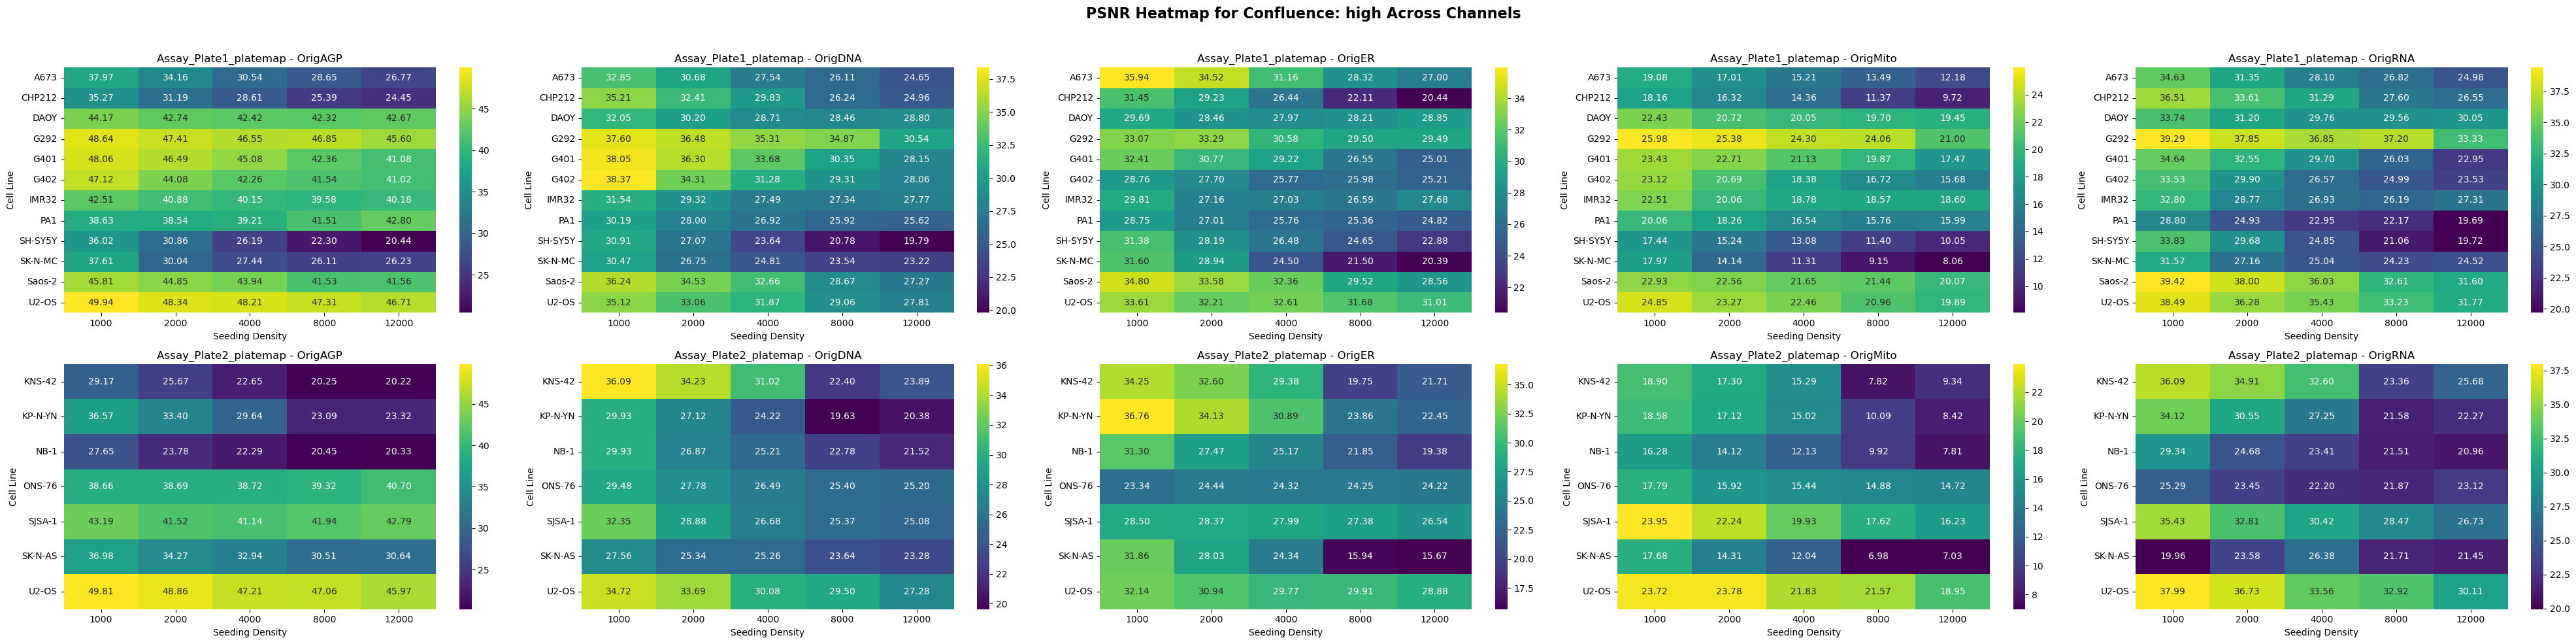

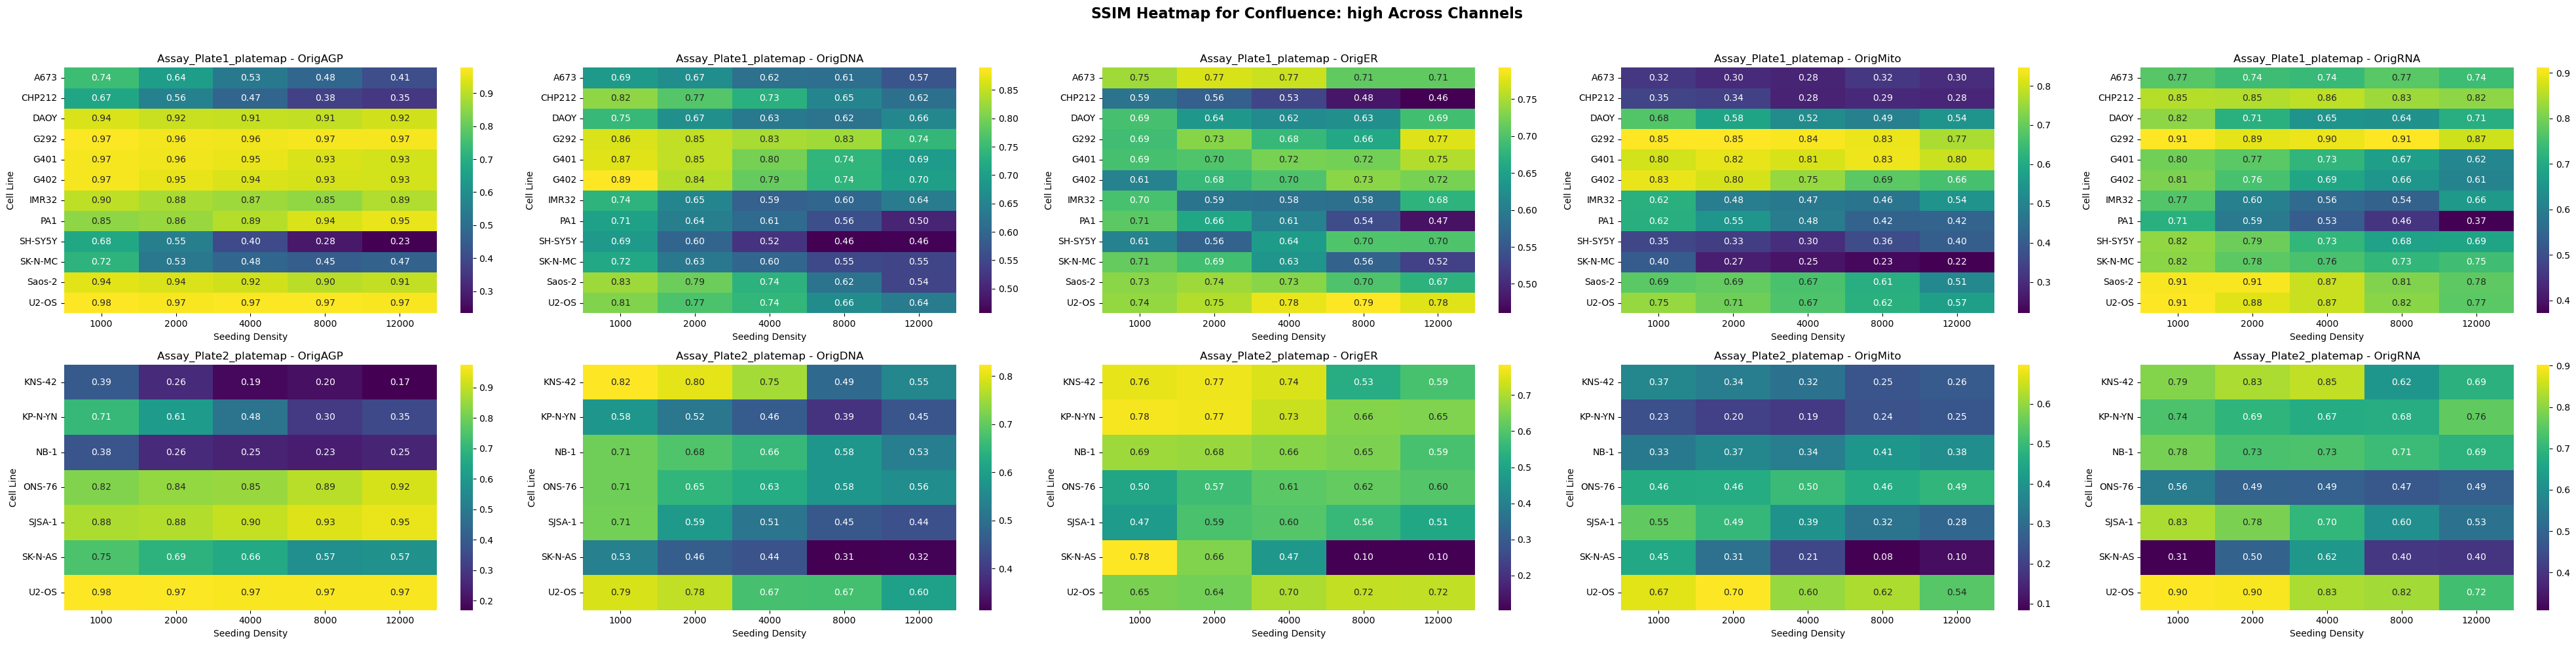

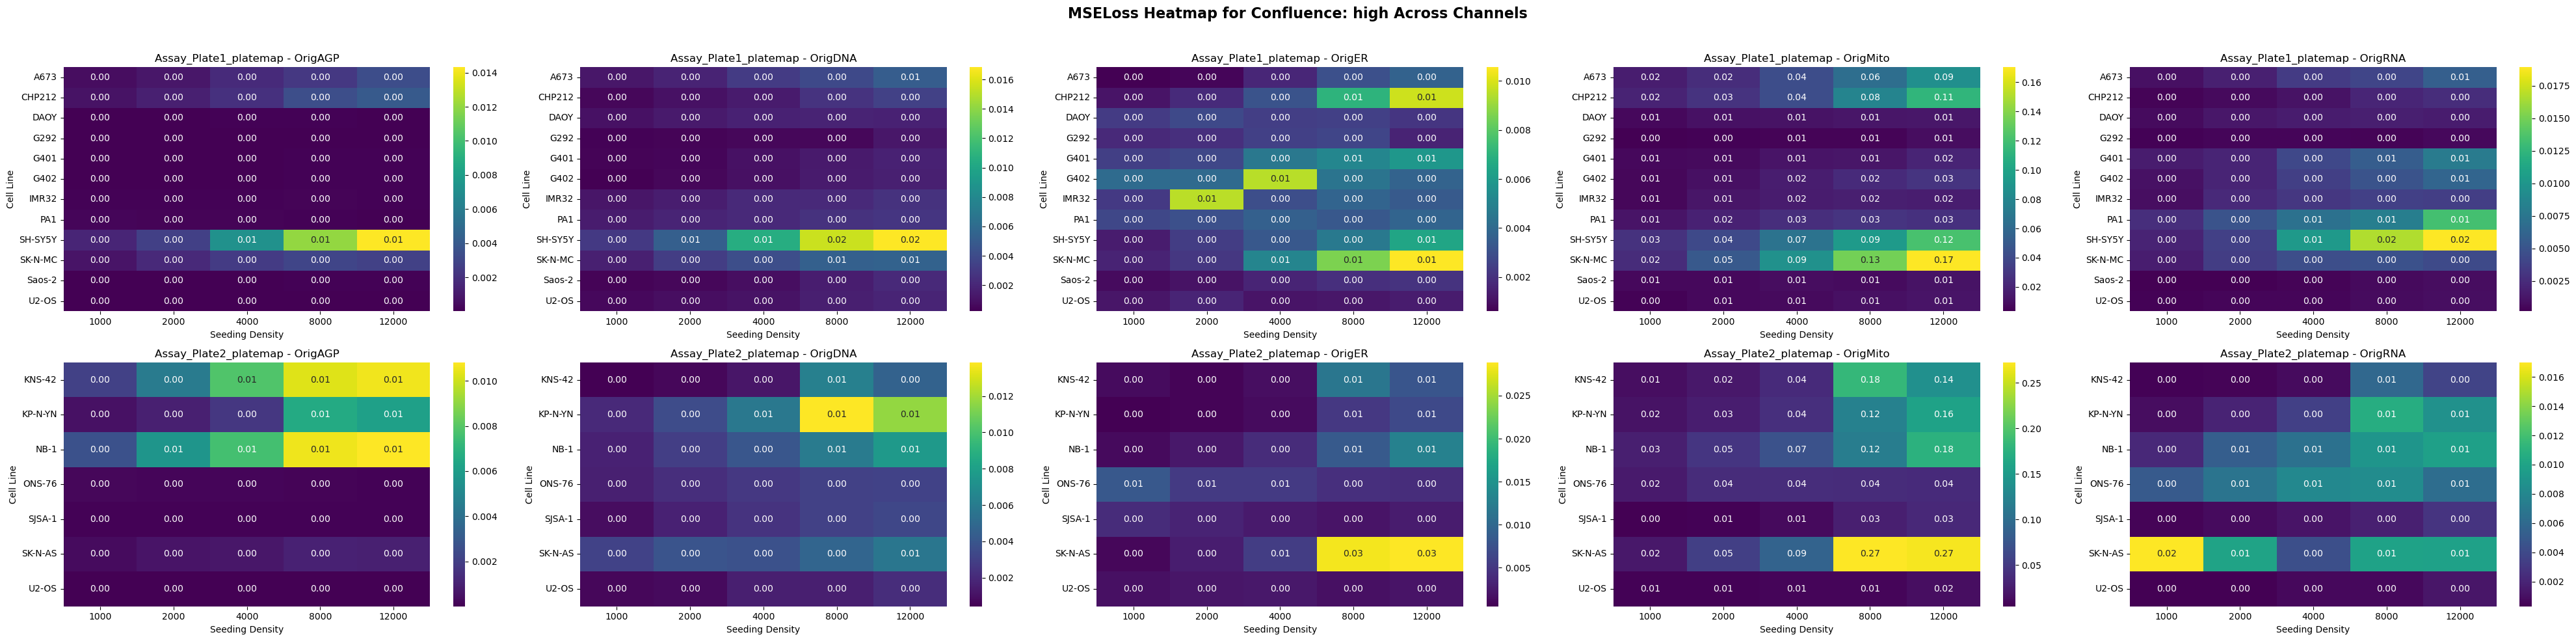

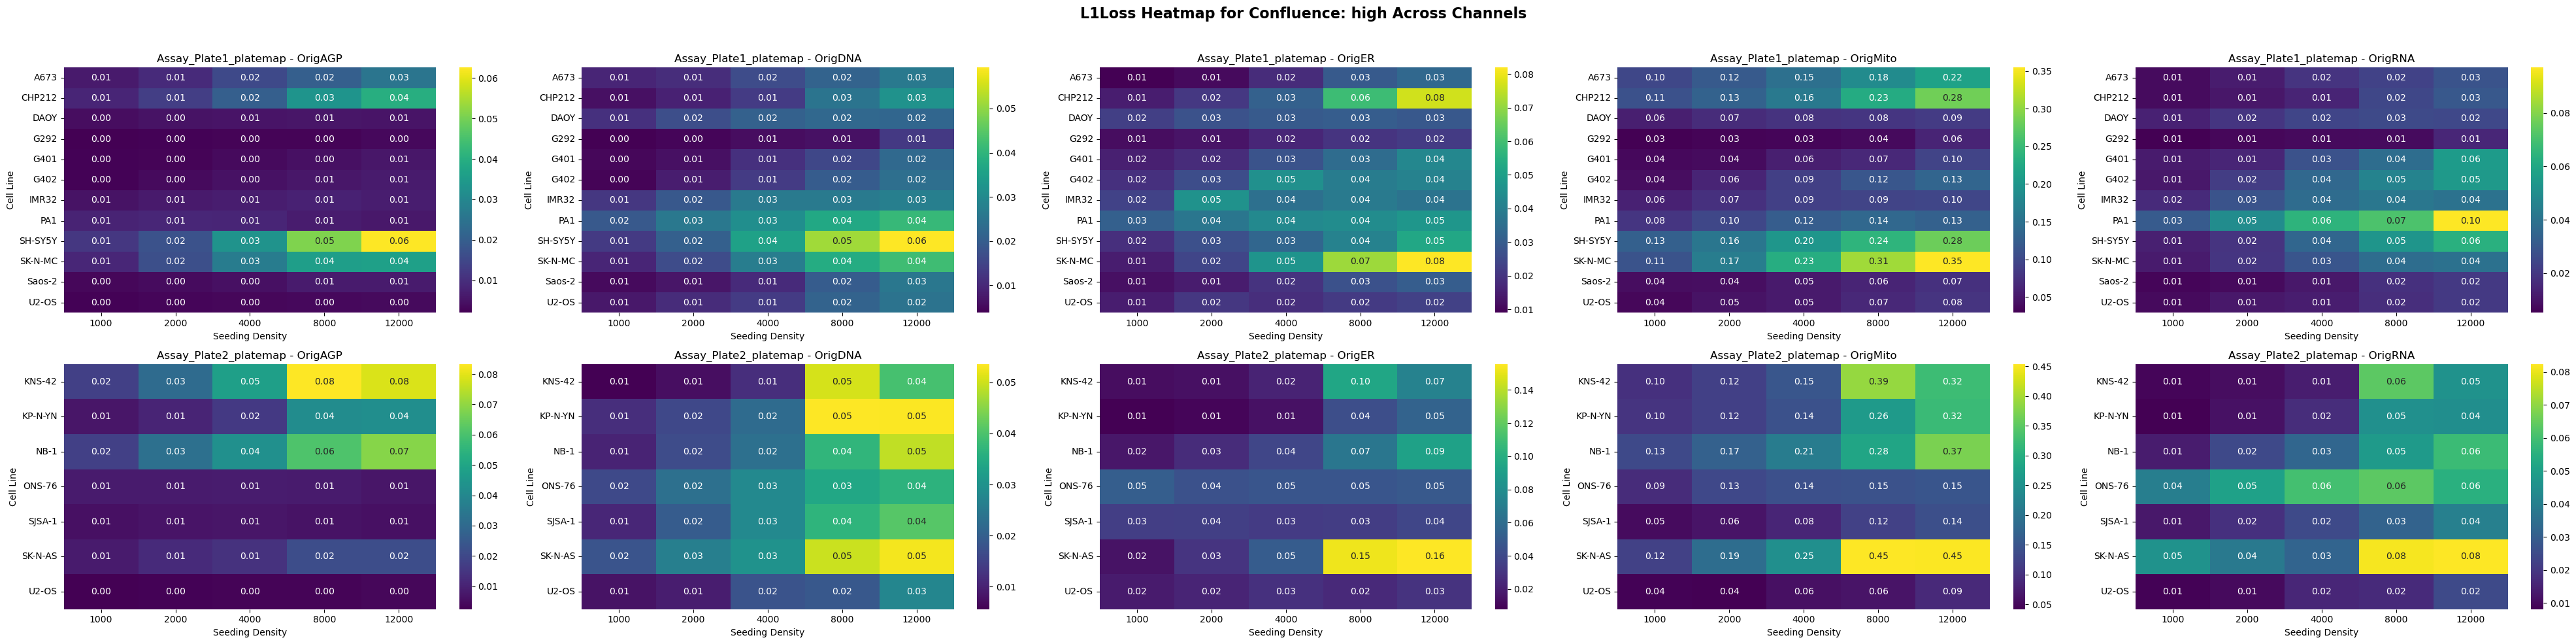

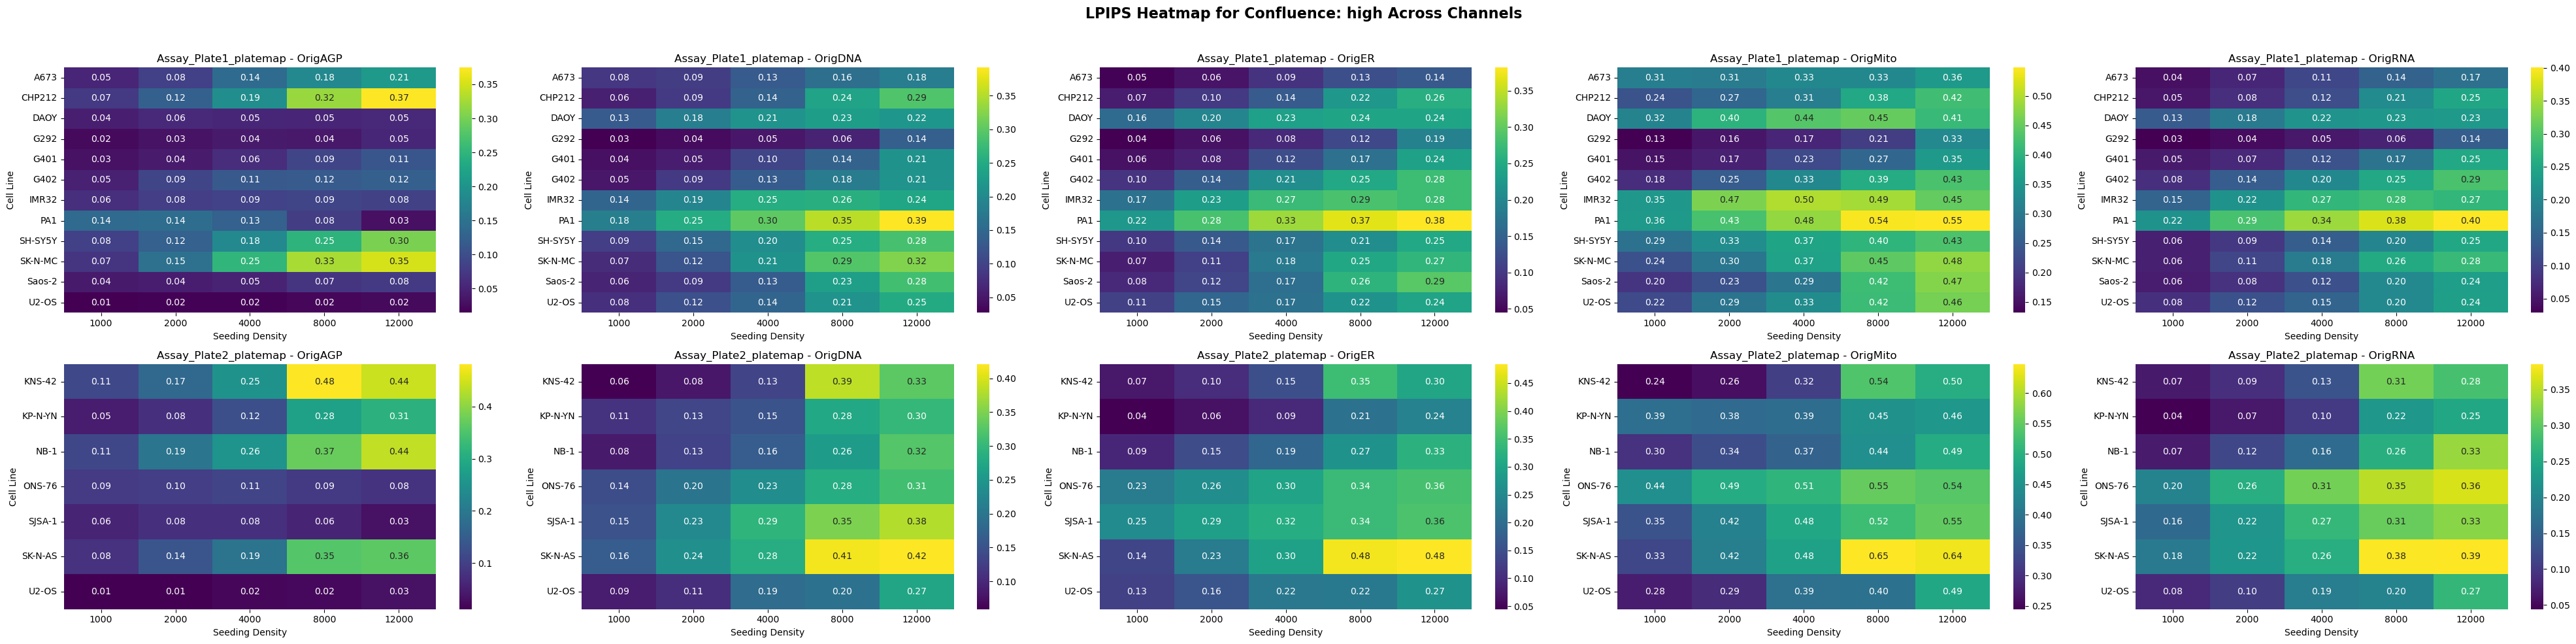

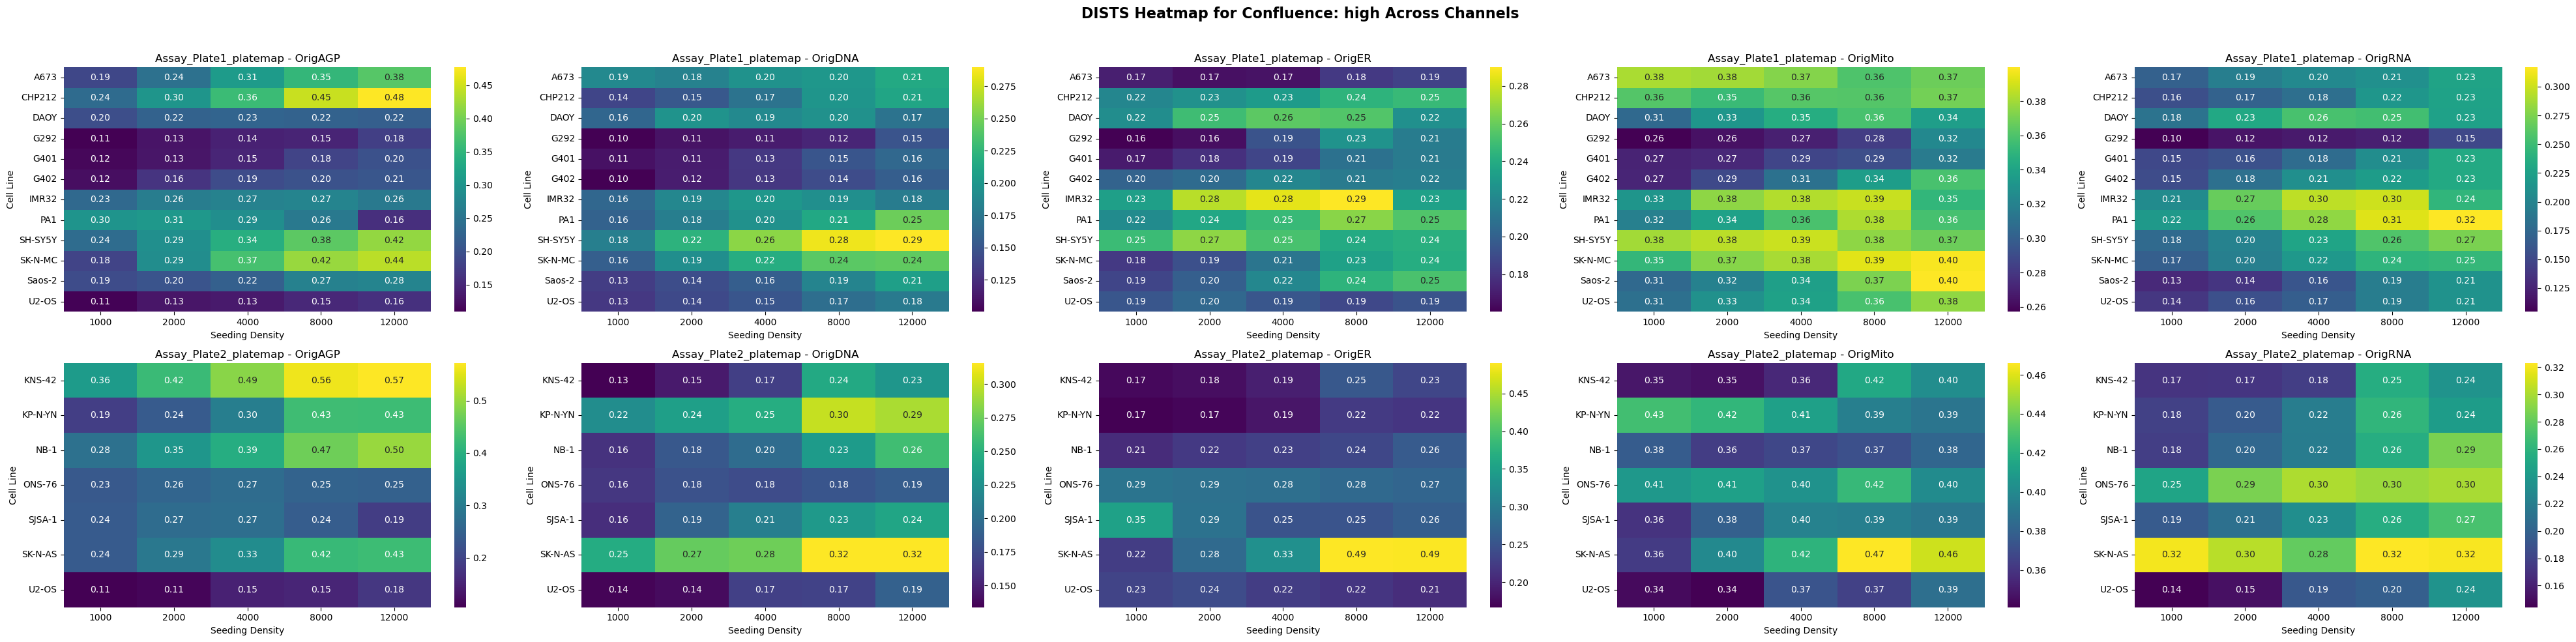

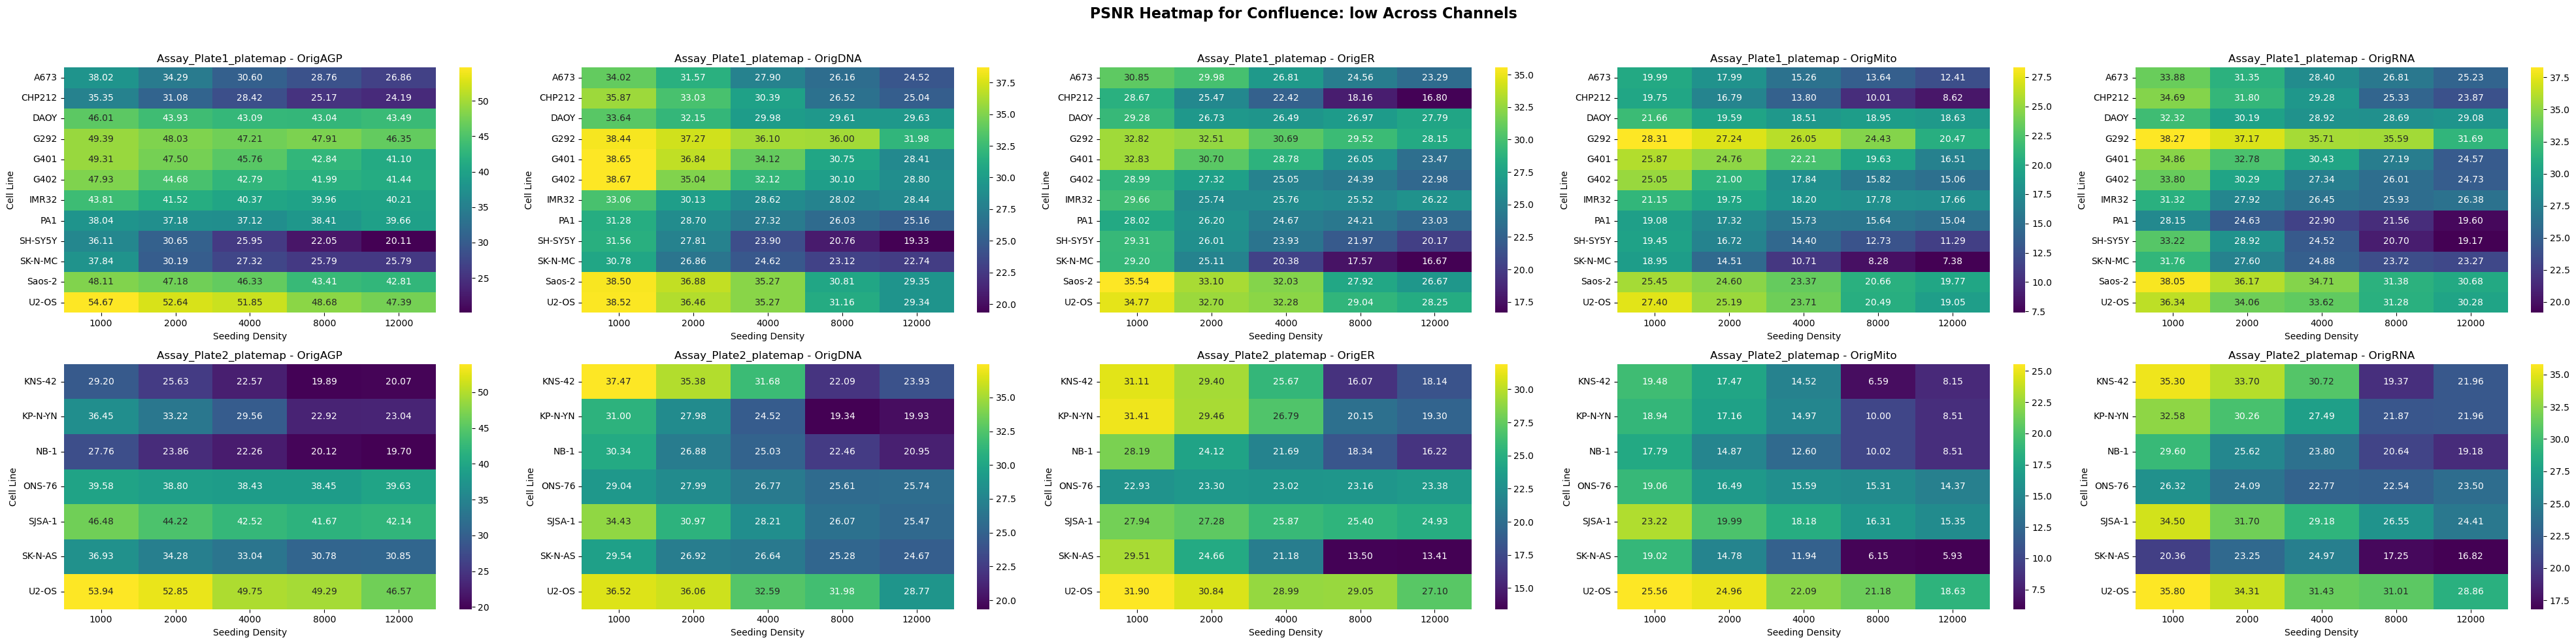

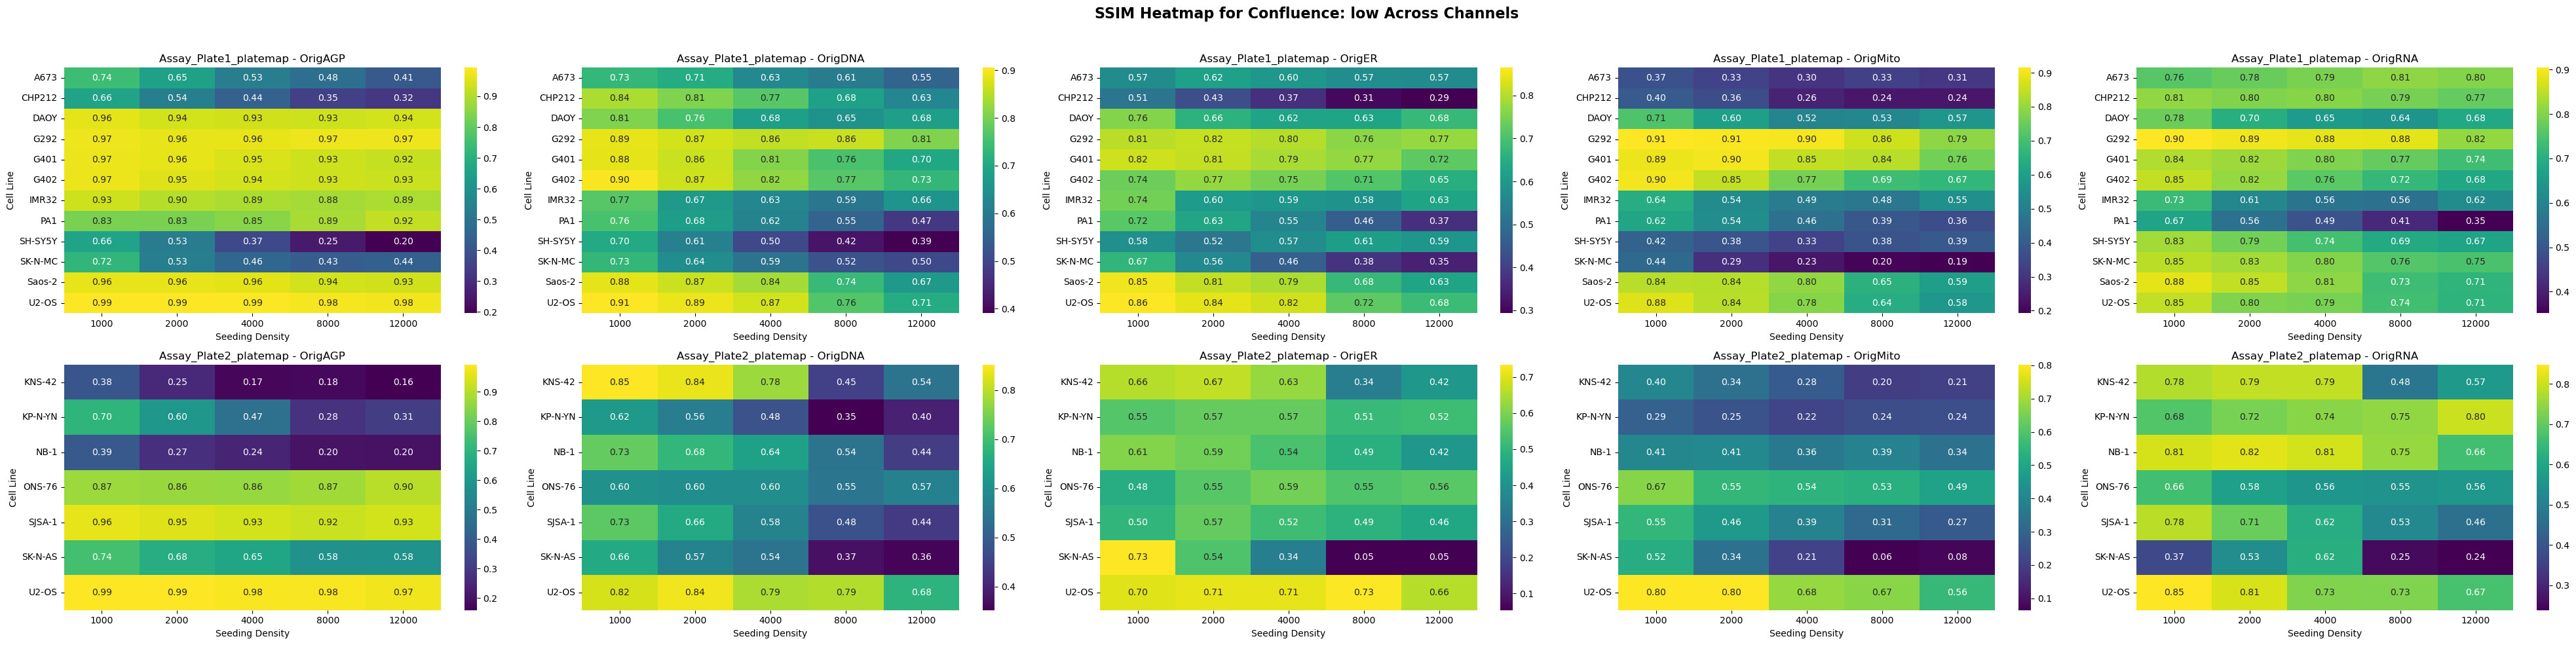

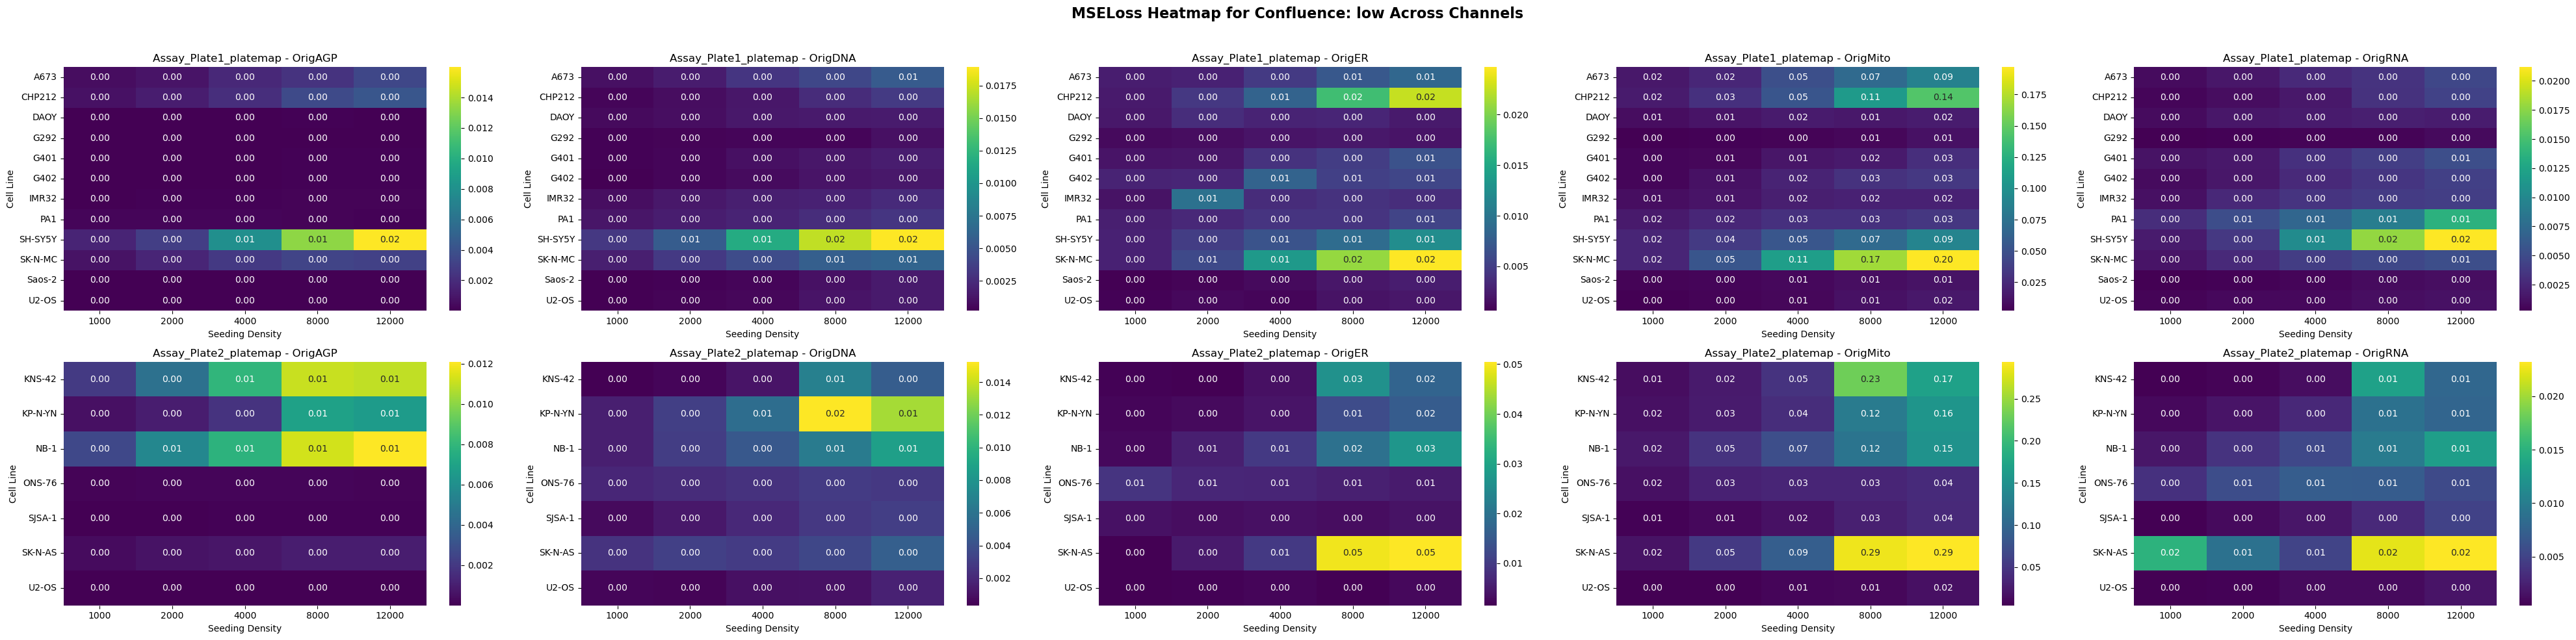

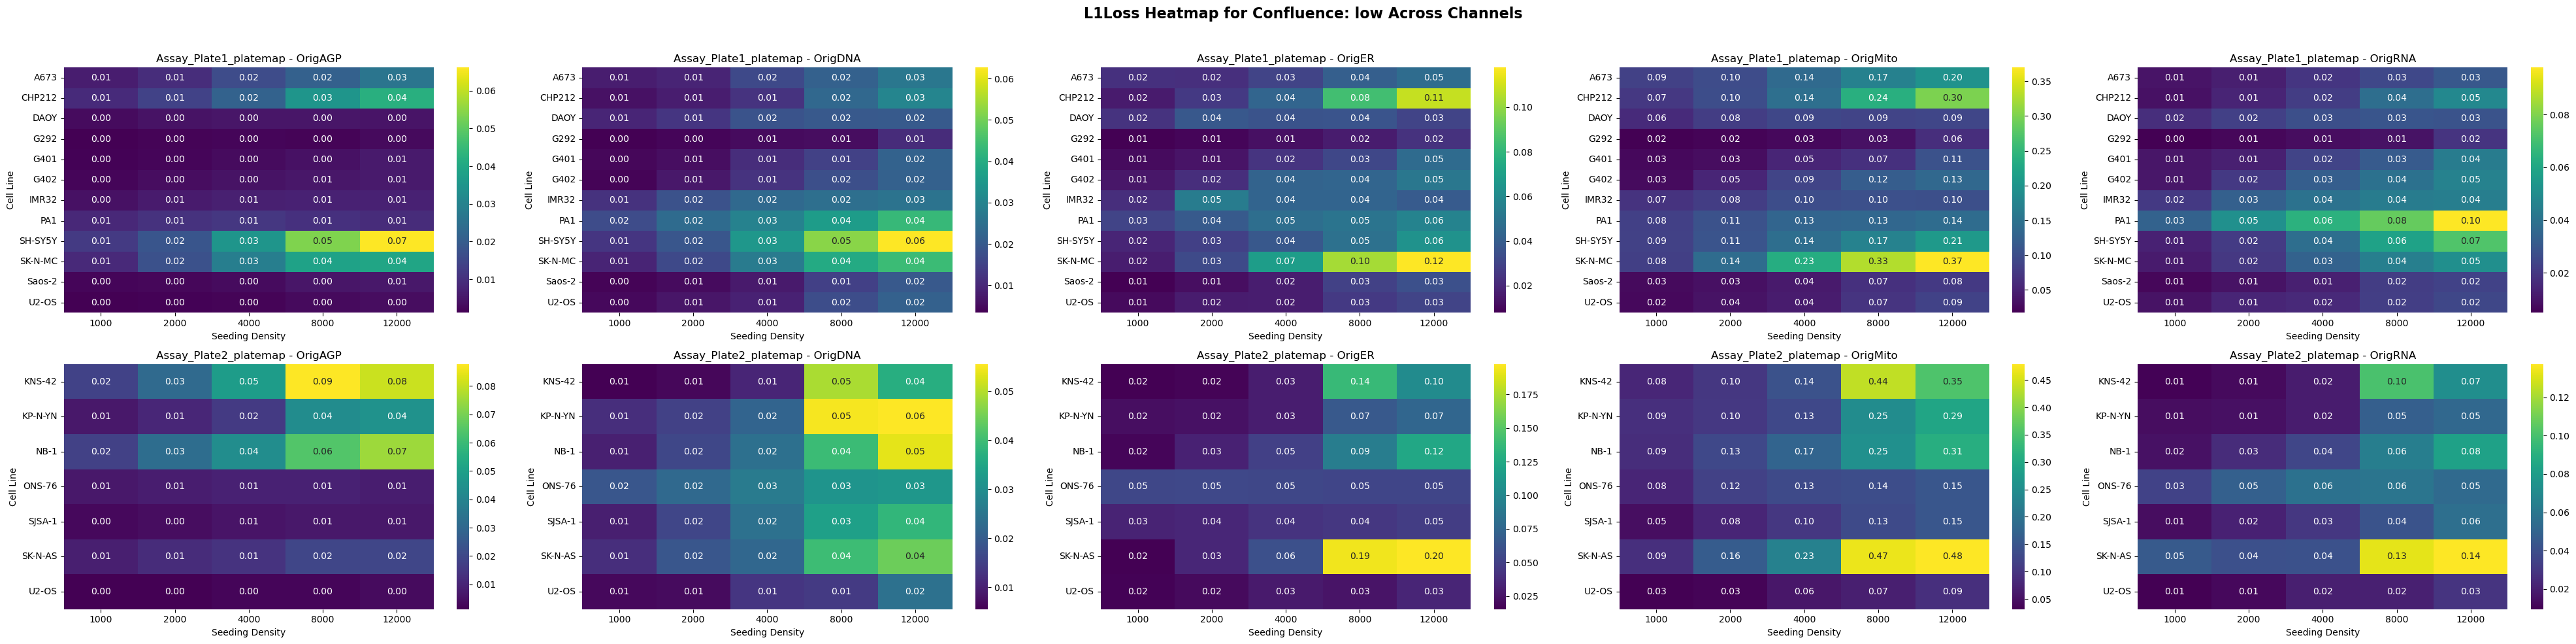

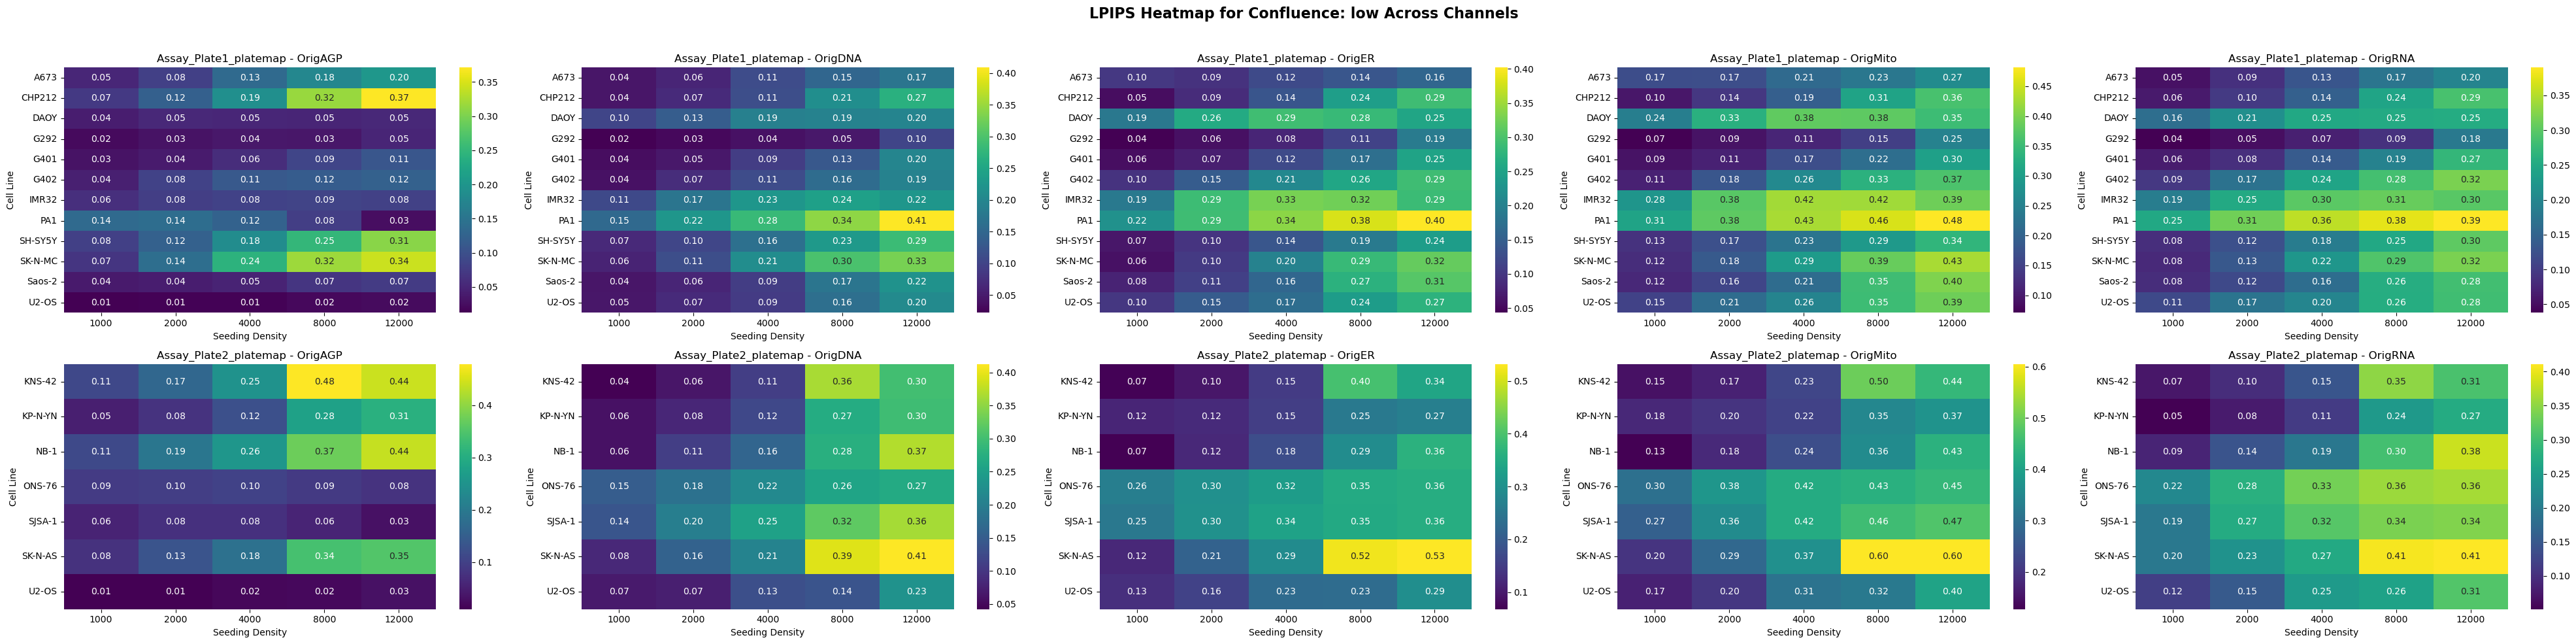

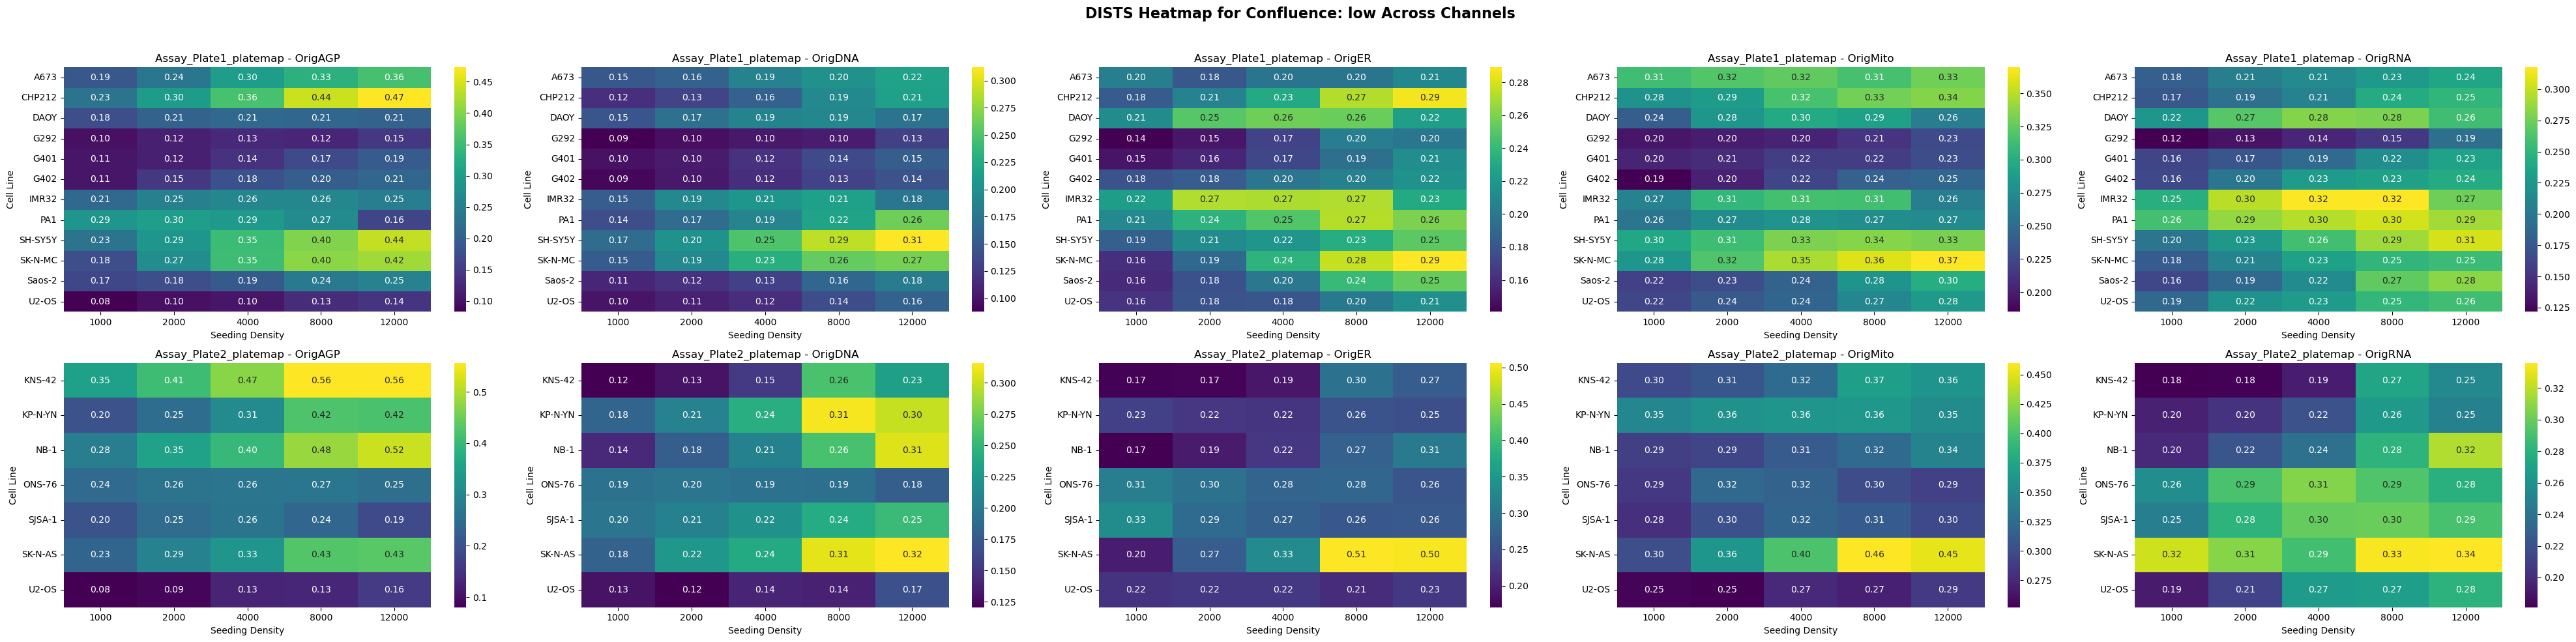

In [14]:
metrics_columns = [
    metric.__class__.__name__ for metric in  EVAL_METRICS
]

# Group by run_name
grouped = all_metrics_df.groupby('confluence')

for confluence_group, group in grouped:
    # Get unique platemap_file and params.channel_name
    unique_platemaps = group['platemap_file'].unique()
    unique_channels = group['params.channel_name'].unique()

    for metric_column in metrics_columns:
    
        # Create a grid of subplots
        fig, axes = plt.subplots(len(unique_platemaps), len(unique_channels), figsize=(40, 10), sharex=False, sharey=False)
        fig.suptitle(f'{metric_column} Heatmap for Confluence: {confluence_group} Across Channels', fontsize=16, fontweight='bold')
        
        for i, platemap in enumerate(unique_platemaps):

            for j, channel in enumerate(unique_channels):
                ax = axes[i, j] if len(unique_platemaps) > 1 and len(unique_channels) > 1 else axes[max(i, j)]
                subset = group[(group['platemap_file'] == platemap) & (group['params.channel_name'] == channel)]
            
                if len(subset) == 0:
                    continue

                heatmap_data = subset.pivot_table(index='cell_line', columns='seeding_density', values=metric_column, aggfunc='mean')
                sns.heatmap(heatmap_data, ax=ax, cmap='viridis', annot=True, fmt=".2f")
                ax.set_title(f'{platemap} - {channel}')
                ax.set_xlabel('Seeding Density')
                ax.set_ylabel('Cell Line')
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()